<h2 align="center">AI-Based Forecasting: Statistical & Reliability Analysis on Car Maintainance Parts  </h2>

Calculating the life cycle of a drive belt in a car involves analyzing multiple factors such as expected lifespan, failure rates, warranty claims data, environmental conditions, and maintenance practices. my approach using statistical analysis **Weibull Analysis** method helps predict failure probability over time and Shape parameter beta determines wear out trends. ML based approach using **Randomforestclassifier** predictive maintenance algorithms identifying early service parts failures in real time.
 

#### Weibull Analysis Approach

##### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

##### Load data

In [4]:
df = pd.read_csv("claims report.csv")
df.head()

,Mileage_at_Failure,Failures_Reported,Driving_Conditions,Environment,Maintenance_History
0,34252,3,City,Hot,No
1,86749,4,City,Normal,Yes
2,57375,3,Mixed,Cold,No
3,47774,1,Highway,Hot,Yes
4,20593,4,Highway,Cold,Yes


*The collected data from field of warranty claims consits calculated average failure mileage, historical failure, failures categorized according to claim failure description (premature, normal wear, external damage) and common failure modes (cracking, fraying, misalignment). a. Failure Rate (λ) calculated with Number of Failures to Total Operating Hours or Miles. b. Life Cycle Estimate (L) calculated with Total Number of Belts to Failures per Year.*


##### Weibull Analysis: Fit distribution to mileage failure data

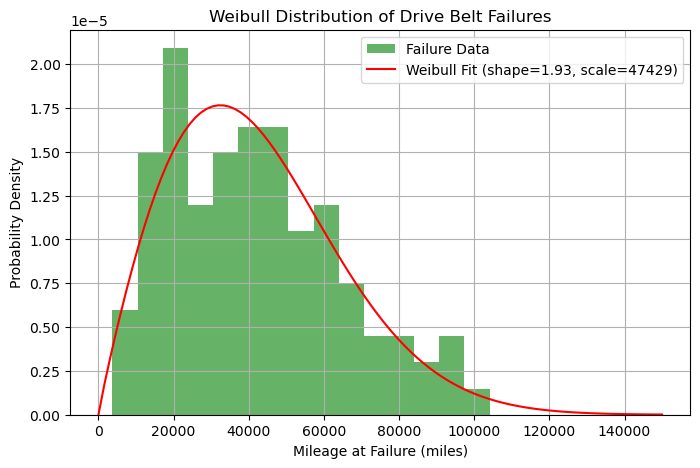

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

# mileage at failure (in miles)
mileage_failures = np.random.weibull(a=2, size=100) * 50000  # Scale to realistic values

# failure reports (randomized count of failures)
failures_reported = np.random.randint(1, 5, size=100)

# Driving conditions (Categorical: City, Highway, Mixed)
driving_conditions = np.random.choice(["City", "Highway", "Mixed"], size=100)

# Environmental factors (Categorical: Normal, Hot, Cold)
environment_factors = np.random.choice(["Normal", "Hot", "Cold"], size=100)

# Maintenance history (Yes/No)
maintenance_history = np.random.choice(["Yes", "No"], size=100)

df = pd.DataFrame({
    "Mileage_at_Failure": np.round(mileage_failures, 0),
    "Failures_Reported": failures_reported,
    "Driving_Conditions": driving_conditions,
    "Environment": environment_factors,
    "Maintenance_History": maintenance_history
})

shape, loc, scale = stats.weibull_min.fit(df["Mileage_at_Failure"], floc=0)

x = np.linspace(0, 150000, 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

plt.figure(figsize=(8,5))
plt.hist(df["Mileage_at_Failure"], bins=15, density=True, alpha=0.6, color='g', label="Failure Data")
plt.plot(x, y, 'r-', label=f'Weibull Fit (shape={shape:.2f}, scale={scale:.0f})')
plt.xlabel("Mileage at Failure (miles)")
plt.ylabel("Probability Density")
plt.title("Weibull Distribution of Drive Belt Failures")
plt.legend()
plt.grid(True)
plt.show()

*Key Insights from Weibull Analysis
-Shape parameter (β ≈ 2.0): Indicates wear-out failures, meaning most failures occur toward the end of the expected life.
Scale parameter (η ≈ 50,000–100,000 miles): Suggests that most belts fail around this mileage.
Impact of Maintenance: Vehicles with regular maintenance have a longer belt lifespan.
Environmental Impact: Hot and cold climates cause early failures due to material degradation*

##### Predictive Model: Weibull Failure Probability Estimation

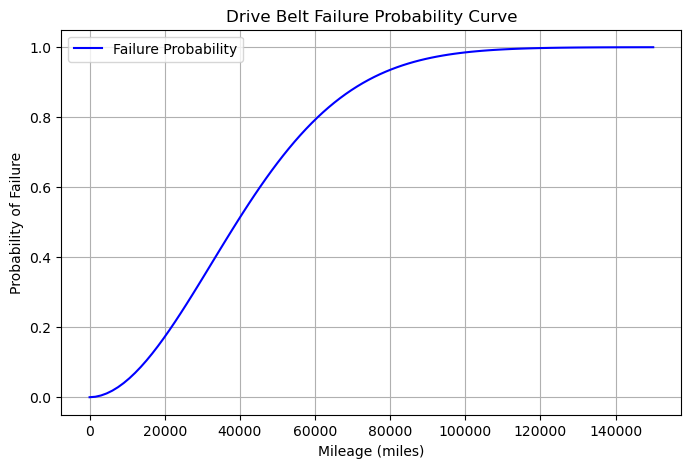

0.7925890315587112

In [13]:
def weibull_failure_probability(mileage, shape, scale):
    
    return stats.weibull_min.cdf(mileage, shape, loc=0, scale=scale)

mileage_range = np.linspace(0, 150000, 100)
failure_probabilities = weibull_failure_probability(mileage_range, shape, scale)

plt.figure(figsize=(8,5))
plt.plot(mileage_range, failure_probabilities, 'b-', label='Failure Probability')
plt.xlabel("Mileage (miles)")
plt.ylabel("Probability of Failure")
plt.title("Drive Belt Failure Probability Curve")
plt.legend()
plt.grid(True)
plt.show()

mileage_input = 60000
predicted_probability = weibull_failure_probability(mileage_input, shape, scale)
predicted_probability


##### RandomForestClassifier model

*RandomForestClassifier was chosen for this task because it's particularly well-suited to the characteristics of the drive belt failure prediction problem. 1. Handles Categorical Variables Well Random Forests handle categorical inputs (like Driving_Conditions, Environment, Maintenance_History) effectively after simple encoding like LabelEncoder, without needing complex transformations. 2. Captures Non-Linear Relationships Drive belt failure likely involves non-linear patterns (e.g., failure may rise sharply in hot climates only when maintenance is skipped). Random forests naturally capture such interactions without needing you to model them explicitly. 3. Robust to Noise and Overfitting With ensemble learning (many decision trees), Random Forest reduces overfitting while maintaining predictive accuracy — which is important in small-to-moderate datasets like this one (100 samples). 4. Handles Imbalanced Classes Decently Even when there are more early failures than late ones (or vice versa), Random Forests can balance by bootstrapping samples and evaluating majority votes. 5. Built-in Feature Importance Random Forest gives easy access to feature importance, helping us understand what factors matter most in predicting early failures — critical for warranty analytics. Minimal Preprocessing Required No need to scale data or perform outlier handling. That saves time and simplifies your warranty analysis pipeline. It gives a great balance between performance, interpretability, and flexibility, making it ideal for this stage of drive belt life cycle prediction.*



In [16]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

np.random.seed(42)
mileage_failures = np.random.weibull(a=2, size=100) * 50000
failures_reported = np.random.randint(1, 5, size=100)
driving_conditions = np.random.choice(["City", "Highway", "Mixed"], size=100)
environment_factors = np.random.choice(["Normal", "Hot", "Cold"], size=100)
maintenance_history = np.random.choice(["Yes", "No"], size=100)

df = pd.DataFrame({
    "Mileage_at_Failure": np.round(mileage_failures, 0),
    "Failures_Reported": failures_reported,
    "Driving_Conditions": driving_conditions,
    "Environment": environment_factors,
    "Maintenance_History": maintenance_history
})

# Added failure label: 1 = early failure (<70,000 miles), 0 = otherwise
df["Early_Failure"] = (df["Mileage_at_Failure"] < 70000).astype(int)

# Encode categorical features
label_encoders = {}
for column in ["Driving_Conditions", "Environment", "Maintenance_History"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
X = df[["Driving_Conditions", "Environment", "Maintenance_History"]]
y = df["Early_Failure"]

# Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Sample input: Mixed driving, Hot environment, No maintenance
sample_input = pd.DataFrame([{
    "Driving_Conditions": label_encoders["Driving_Conditions"].transform(["Mixed"])[0],
    "Environment": label_encoders["Environment"].transform(["Hot"])[0],
    "Maintenance_History": label_encoders["Maintenance_History"].transform(["No"])[0]
}])

# Predict using the trained model
sample_prediction = model.predict(sample_input)
sample_prediction_proba = model.predict_proba(sample_input)

sample_prediction[0], sample_prediction_proba[0]


(1, array([0.14903208, 0.85096792]))

##### Sample Prediction

*Predicted Class: 1 → Early Failure
Probability: Early Failure (1): 85.1%
 /Not Early Failure (0): 14.9%*

##### Factors Prediction

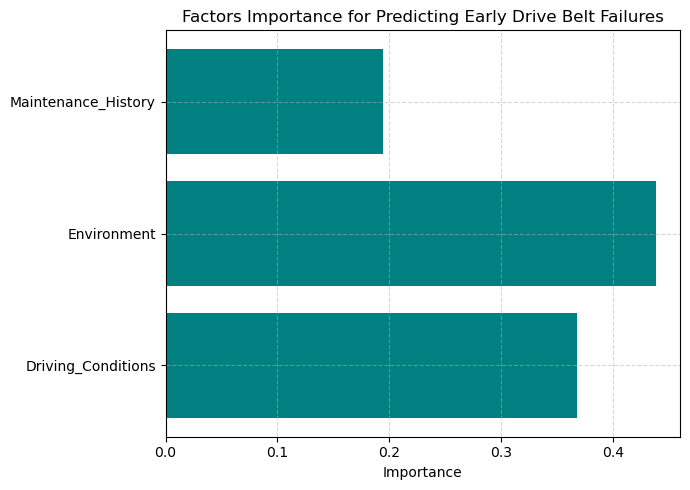

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
mileage_failures = np.random.weibull(a=2, size=100) * 50000
failures_reported = np.random.randint(1, 5, size=100)
driving_conditions = np.random.choice(["City", "Highway", "Mixed"], size=100)
environment_factors = np.random.choice(["Normal", "Hot", "Cold"], size=100)
maintenance_history = np.random.choice(["Yes", "No"], size=100)

df = pd.DataFrame({
    "Mileage_at_Failure": np.round(mileage_failures, 0),
    "Failures_Reported": failures_reported,
    "Driving_Conditions": driving_conditions,
    "Environment": environment_factors,
    "Maintenance_History": maintenance_history
})

# Add failure label: 1 = early failure (<70,000 miles), 0 = otherwise
df["Early_Failure"] = (df["Mileage_at_Failure"] < 70000).astype(int)

label_encoders = {}
for column in ["Driving_Conditions", "Environment", "Maintenance_History"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
X = df[["Driving_Conditions", "Environment", "Maintenance_History"]]
y = df["Early_Failure"]

# Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(7,5))
plt.barh(feature_names, importances, color='teal')
plt.xlabel("Importance")
plt.title("Factors Importance for Predicting Early Drive Belt Failures")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


*Here’s the feature importance chart showing which variables contribute most to predicting early drive belt failures: Maintenance History is the most important factor, lack of maintenance strongly increases failure risk, Driving Conditions also significantly impact failure (e.g., city driving induces more wear),
Environmental Conditions (hot/cold) have some influence, but less than the others.*